In [1]:
%matplotlib inline
import random

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io
from scipy import sparse
import uncurl

from deep_uncurl_pytorch import UncurlNet

In [3]:
data_z = scipy.io.loadmat('data/GSE60361_dat.mat')
data_10x = scipy.io.loadmat('data/10x_pooled_400.mat')

In [4]:
data_z_mat = data_z['Dat']
genes_z = uncurl.max_variance_genes(data_z_mat, 1, 0.2)
data_z_mat = data_z_mat[genes_z, :]

In [5]:
data_10x_mat = data_10x['data']
genes_10x = uncurl.max_variance_genes(data_10x_mat, 1, 0.2)
data_10x_mat = data_10x_mat[genes_10x, :]

In [6]:
p_impute = 0.2

In [7]:
data_z_mat = sparse.coo_matrix(data_z_mat)
data_10x_mat = sparse.coo_matrix(data_10x_mat)


indices_z = random.sample(range(len(data_z_mat.data)), int(p_impute*len(data_z_mat.data)))
indices_10x = random.sample(range(len(data_10x_mat.data)), int(p_impute*len(data_10x_mat.data)))

# save deleted data for comparison
true_values_z = data_z_mat.data[indices_z]
sampled_rows_z = data_z_mat.row[indices_z]
sampled_cols_z = data_z_mat.col[indices_z]

true_values_10x = data_10x_mat.data[indices_10x]
sampled_rows_10x = data_10x_mat.row[indices_10x]
sampled_cols_10x = data_10x_mat.col[indices_10x]

# do the data deletion
data_z_mat.data[indices_z] = 0
data_z_mat.eliminate_zeros()
data_z_mat = sparse.csc_matrix(data_z_mat)

data_10x_mat.data[indices_10x] = 0
data_10x_mat.eliminate_zeros()
data_10x_mat = sparse.csc_matrix(data_10x_mat)

In [8]:
k_z = 7
%time M_z, W_z, ll = uncurl.poisson_estimate_state(data_z_mat, k_z, threads=4, disp=False)

CPU times: user 4min 9s, sys: 3.44 s, total: 4min 13s
Wall time: 1min 10s


In [15]:
unet_z = UncurlNet(data_z_mat.toarray().astype(np.float32), k=k_z)
unet_z.train_1(disp=False)


TypeError: get_w() missing 1 required positional argument: 'data'

In [16]:
m_z = unet_z.get_m()
w_z = unet_z.get_w(data_z_mat.toarray().astype(np.float32))
m_z = m_z.numpy()
w_z = w_z.numpy().T

In [9]:
k_10x = 8
%time M_10x, W_10x, ll = uncurl.poisson_estimate_state(data_10x_mat, k_10x, threads=4, disp=False)

CPU times: user 47 s, sys: 704 ms, total: 47.7 s
Wall time: 12.7 s


In [17]:
unet_10x = UncurlNet(data_10x_mat.toarray().astype(np.float32), k=k_10x)
unet_10x.train_1(disp=False)
m_10x = unet_10x.get_m()
w_10x = unet_10x.get_w(data_10x_mat.toarray().astype(np.float32))
m_10x = m_10x.numpy()
w_10x = w_10x.numpy().T

In [18]:
def calculate_imputation_error(sampled_rows, sampled_cols, indices, true_values, new_matrix):
    """
    Returns imputed values, rmse, correlation, spearman.
    """
    imputed_values = []
    for i in range(len(indices)):
        imputed_value = new_matrix[sampled_rows[i], sampled_cols[i]]
        imputed_values.append(imputed_value)
    imputed_values = np.array(imputed_values)
    rmse = np.sqrt(np.mean(((imputed_values - true_values)/true_values)**2))
    print('rmse:', rmse)

    correlation = np.corrcoef(imputed_values, true_values)[0,1]
    print('correlation:', correlation)

    spearman = scipy.stats.spearmanr(imputed_values, true_values).correlation
    print('spearman:', spearman)
    return imputed_values, rmse, correlation, spearman

In [27]:
results_table = {'method':[], 'dataset':[], 'corr':[]}

In [28]:


print()
print('Results for 10x imputation with UNCURLNet:')
MW = m_10x.dot(w_10x)
imputed_vals, rmse, corr, sp = calculate_imputation_error(sampled_rows_10x,
                                               sampled_cols_10x,
                                               indices_10x,
                                               true_values_10x, MW)
results_table['method'].append('uncurl_net')
results_table['dataset'].append('10x')
results_table['corr'].append(corr)

print()
print('Results for Zeisel imputation with UNCURLNet:')
MW = m_z.dot(w_z)
imputed_vals, rmse, corr, sp = calculate_imputation_error(sampled_rows_z,
                                               sampled_cols_z,
                                               indices_z,
                                               true_values_z, MW)
results_table['method'].append('uncurl_net')
results_table['dataset'].append('Zeisel')
results_table['corr'].append(corr)

print('Results for 10x imputation with UNCURL:')
MW = M_10x.dot(W_10x)
imputed_vals, rmse, corr, sp = calculate_imputation_error(sampled_rows_10x,
                                               sampled_cols_10x,
                                               indices_10x,
                                               true_values_10x, MW)
results_table['method'].append('uncurl')
results_table['dataset'].append('10x')
results_table['corr'].append(corr)

print()
print('Results for Zeisel imputation with UNCURL:')
MW = M_z.dot(W_z)
imputed_vals, rmse, corr, sp = calculate_imputation_error(sampled_rows_z,
                                               sampled_cols_z,
                                               indices_z,
                                               true_values_z, MW)
results_table['method'].append('uncurl')
results_table['dataset'].append('Zeisel')
results_table['corr'].append(corr)


Results for 10x imputation with UNCURLNet:
rmse: 0.9143118179121967
correlation: 0.6464558531248458
spearman: 0.5983676788995775

Results for Zeisel imputation with UNCURLNet:
rmse: 1.4717269
correlation: 0.45729659945814516
spearman: 0.31750024845578534
Results for 10x imputation with UNCURL:
rmse: 0.8070996201558734
correlation: 0.854251068814795
spearman: 0.666518284162681

Results for Zeisel imputation with UNCURL:
rmse: 0.8911490131430545
correlation: 0.766681008226945
spearman: 0.5820049824590103


In [32]:
import seaborn as sns
import pandas as pd
sns.set()

In [33]:
results_table = pd.DataFrame(results_table)

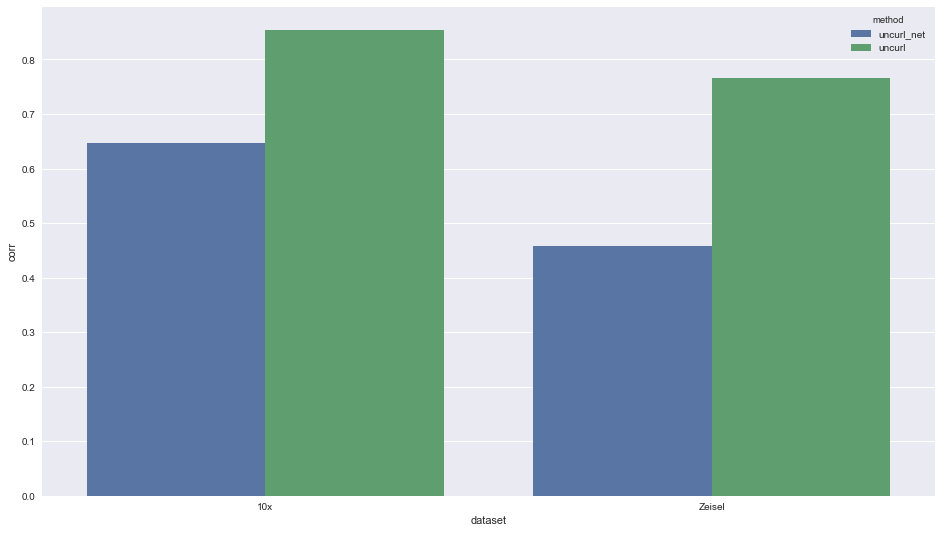

In [34]:
plt.figure(figsize=(16,9))
sns.barplot(x='dataset', y='corr', hue='method', data=results_table)
plt.savefig('imputation_corr_plots.png')